In [2]:
import networkx as nx
import random
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import community
import matplotlib.pyplot as plt
import community
import cairocffi
import igraph

In [3]:
# Load the Email-Eu-Core dataset
G = nx.read_edgelist("C:\MTech\Second Semester\Web and Social Computing(IT752)\Project\Email-EuAll.txt")

In [24]:
# saving graph created above in gexf format
nx.write_gexf(G, "Email-EUAll.gexf")

In [4]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(num_nodes)
print(num_edges)
seeds = random.sample(list(G.nodes), num_nodes//20000)
print(seeds)

265214
365570
['23755', '150957', '198227', '120382', '116232', '242621', '264324', '65927', '13498', '248281', '81974', '93172', '83054']


In [5]:
# Define the number of hash functions
num_hashes = 100

In [6]:
# Define the number of bands
num_bands = 25

In [7]:
# Define the number of rows per band
rows_per_band = num_hashes // num_bands

In [8]:
# Define the prime number for hashing
prime = 4294967311

In [9]:
# Define the maximum hash value
max_hash = 2**32 - 1

In [10]:
# Define the minhash signature function
def minhash_signature(node, num_hashes):
    # Generate a random permutation of the node neighbors
    neighbors = list(G.neighbors(node))
    random.shuffle(neighbors)

    # Define the hash functions
    def hash_function(a, b, x):
        return ((a * x + b) % prime) % max_hash

    # Generate the minhash signature
    signature = []
    for i in range(num_hashes):
        min_hash = float('inf')
        for neighbor in neighbors:
            hash_value = hash_function(i+1, i+1, int(neighbor))
            if hash_value < min_hash:
                min_hash = hash_value
        signature.append(min_hash)
    return signature

In [11]:
# Define the LSH function
def LSH(seed, candidates, num_hashes, num_bands, rows_per_band):
    # Generate the minhash signatures for the seed and candidate nodes
    seed_signature = minhash_signature(seed, num_hashes)
    candidate_signatures = [minhash_signature(candidate, num_hashes) for candidate in candidates]

    # Define the bands
    bands = []
    for i in range(num_bands):
        band = []
        for j in range(rows_per_band):
            band.append(i * rows_per_band + j)
        bands.append(band)

    # Define the hash table
    hash_table = {}
    for i, candidate_signature in enumerate(candidate_signatures):
        for band in bands:
            key = tuple(candidate_signature[j] for j in band)
            if key not in hash_table:
                hash_table[key] = []
            hash_table[key].append(i)

    # Find the candidates that are near to the seed
    near_candidates = set()
    for band in bands:
        key = tuple(seed_signature[j] for j in band)
        if key in hash_table:
            near_candidates.update(hash_table[key])
    return near_candidates

In [12]:
#Following set is going to have all candidate values that are related to atleast one of the input seeds
absolute_candidate_set = set()
list_of_candidate_sets = []
# Apply the LSH function to each input seed node
for seed in seeds:
    candidates = list(G.nodes())
    candidates.remove(seed)
    near_candidates = LSH(seed, candidates, num_hashes, num_bands, rows_per_band)
    list_of_candidate_sets.append(near_candidates)
    absolute_candidate_set = absolute_candidate_set | near_candidates
    print(f"Seed node: {seed}")
    print(f"Near candidates: {near_candidates}")
    
print("\n")
print(absolute_candidate_set)
print("number of all total candidates = " + str(len(absolute_candidate_set)))

Seed node: 23755
Near candidates: {241664, 153630, 251936, 239763, 235557, 192550, 182313, 176172, 231470, 159793, 221239, 172093, 12350, 98369, 159825, 211025, 233555, 159848, 96378, 231639, 16523, 10386, 10387, 10388, 159893, 10389, 10390, 10391, 10392, 159898, 10393, 10394, 10396, 155806, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 12446, 10406, 10407, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 75954, 10417, 10418, 10419, 10420, 10421, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10436, 213185, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 69848, 10456, 10457, 47323, 10458, 10459, 10460, 10461, 10462, 10463, 166114, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497

In [13]:
def select_related_candidates(seeds, candidates, k):
    """
    Select the k candidates that are most associated with the seed set
    
    Parameters:
    - seeds: set
        The set of seed accounts
    - candidates: list of sets
        The list of candidate accounts returned by LSH
    - k: int
        The number of candidates to select
        
    Returns:
    - selected_candidates: list of sets
        The k candidates that are most associated with the seed set
    """
    # Compute the Jaccard similarity score between each candidate and the seed set
    scores = []
    for candidate in candidates:
        score = len(candidate.intersection(seeds)) / len(candidate.union(seeds))
        scores.append(score)

    # Perform agglomerative clustering on the candidate set based on the similarity scores
    clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    similarity_matrix = np.array([[1 - score for score in scores]] * len(scores))
    clustering.fit(similarity_matrix)

    # Get the indices of the candidates in the largest cluster
    cluster_sizes = [list(clustering.labels_).count(i) for i in range(k)]
    largest_cluster_index = cluster_sizes.index(max(cluster_sizes))
    largest_cluster_indices = [i for i in range(len(clustering.labels_)) if clustering.labels_[i] == largest_cluster_index]

    # Select the candidates in the largest cluster
    selected_candidates = [candidates[i] for i in largest_cluster_indices]
    
    #print(selected_candidates)
    for candidate in selected_candidates:
        print(candidate)
    
    return selected_candidates

In [14]:
clustered_data = select_related_candidates(seeds, list_of_candidate_sets, 10)
print(len(clustered_data[0]))

{241664, 153630, 251936, 239763, 235557, 192550, 182313, 176172, 231470, 159793, 221239, 172093, 12350, 98369, 159825, 211025, 233555, 159848, 96378, 231639, 16523, 10386, 10387, 10388, 159893, 10389, 10390, 10391, 10392, 159898, 10393, 10394, 10396, 155806, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 12446, 10406, 10407, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 75954, 10417, 10418, 10419, 10420, 10421, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10436, 213185, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 69848, 10456, 10457, 47323, 10458, 10459, 10460, 10461, 10462, 10463, 166114, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 1050

In [17]:
G_1 = nx.Graph()
edges = G.edges()

# Add nodes with their attributes, such as cluster membership
for cluster in clustered_data:
    for node in cluster:
        G_1.add_node(node, cluster=cluster)

vertices = set(G_1.nodes())
vertices = map(str, vertices)

# Find all edges between the set of vertices
edges = list(G.subgraph(vertices).edges())

# Add edges connecting the nodes
for edge in edges:
    G_1.add_edge(edge[0], edge[1])

print(G_1)

Graph with 2407 nodes and 75 edges


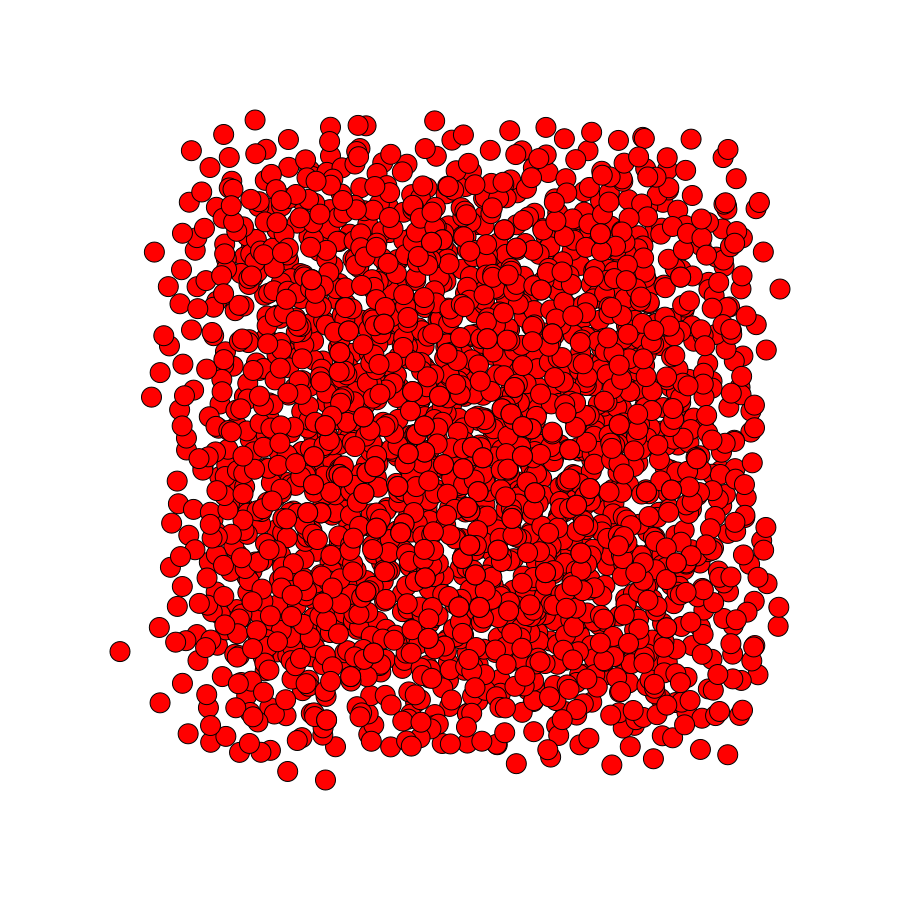

In [28]:
# convert to igraph
g = igraph.Graph.from_networkx(G_1)
layout = g.layout("fruchterman_reingold")
igraph.plot(g, 'Subgraph.png', layout=layout, bbox=(900, 900), margin=120, hovermode='closest')

In [19]:
wtrap = g.community_walktrap(steps = 4)
clust=wtrap.as_clustering()

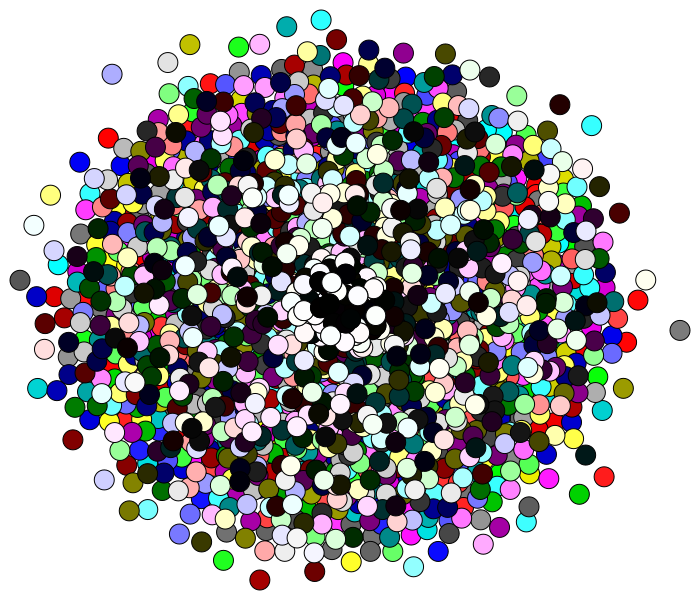

In [20]:
visual_style = dict()
visual_style["bbox"] = (700, 600)
igraph.plot(clust,mark_groups = True,**visual_style)